In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [30]:
#read data for all the stocks
df=pd.read_csv("/content/gdrive/MyDrive/all_stocks_5yr.csv")
#get the data of the stock with the name "AAL"
aal_dataset = df[df.Name == "AAL"]

#get the length of the aal_dataset and the values of the close price
aal_training_len = round(len(aal_dataset))
aal_training_set = aal_dataset.iloc[:, 4:5].values


In [31]:
#we create a MixMaxScaler in order to transform the values the training dataset 
sc = MinMaxScaler(feature_range = (0, 1))
aal_training_set_scaled = sc.fit_transform(aal_training_set.reshape(-1,1))


In [32]:
aal_X_train = []
aal_y_train = []

#we use a window of 20 in order to create the the input and output
window = 20

for i in range(window, aal_training_len):
    aal_X_train.append(aal_training_set_scaled[i-window:i, 0])
    aal_y_train.append(aal_training_set_scaled[i, 0])
aal_X_train, aal_y_train = np.array(aal_X_train), np.array(aal_y_train)

aal_X_train = np.reshape(aal_X_train, (aal_X_train.shape[0], aal_X_train.shape[1], 1))


In [33]:
#we create our model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (aal_X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(aal_X_train, aal_y_train, epochs = 100, batch_size = 32)

Epoch 1/100
39/39 [==============================] - 7s 41ms/step - loss: 0.0591
Epoch 2/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0097
Epoch 3/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0085
Epoch 4/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0083
Epoch 5/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0066
Epoch 6/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0071
Epoch 7/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0077
Epoch 8/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0068
Epoch 9/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0060
Epoch 10/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0064
Epoch 11/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0053
Epoch 12/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0059
Epoch 13/100
39/39 [=====

In [34]:
#we take a new dataset for the testing (GOOGL stock) 
dataset_test = df[df.Name == "GOOGL"]
#we keep only the close price
googl_real_stock_price = dataset_test.iloc[:, 4:5].values

aal_training_set = pd.DataFrame(aal_training_set)
googl_real_stock_price = pd.DataFrame(googl_real_stock_price)

#we create the total dataset 
data_set_total = pd.concat((aal_training_set, googl_real_stock_price), axis = 0)

#we create another MinMaxScaler in order to transform the testing data
googl_scaler = MinMaxScaler(feature_range=(0, 1))
inputs = data_set_total[len(data_set_total) - len(googl_real_stock_price) - window:].values
inputs = inputs.reshape(-1,1)
inputs = googl_scaler.fit_transform(inputs)

In [35]:
#we create the test X_test
googl_X_test = []
for i in range(window, len(inputs)):
    googl_X_test.append(inputs[i-window:i, 0])
googl_X_test = np.array(googl_X_test)
googl_X_test = np.reshape(googl_X_test, (googl_X_test.shape[0], googl_X_test.shape[1], 1))

#we make the predictions based on the model which created in the previous steps
googl_predicted_stock_price = model.predict(googl_X_test)
googl_predicted_stock_price = googl_scaler.inverse_transform(googl_predicted_stock_price)
print(googl_X_test)
print(len(googl_X_test))


[[[0.00353313]
  [0.0058534 ]
  [0.00765512]
  ...
  [0.        ]
  [0.00124802]
  [0.00144138]]

 [[0.0058534 ]
  [0.00765512]
  [0.00722447]
  ...
  [0.00124802]
  [0.00144138]
  [0.30173818]]

 [[0.00765512]
  [0.00722447]
  [0.00738267]
  ...
  [0.00144138]
  [0.30173818]
  [0.3004405 ]]

 ...

 [[0.93208824]
  [0.93553349]
  [0.93428546]
  ...
  [0.99530673]
  [0.99475303]
  [0.93991914]]

 [[0.93553349]
  [0.93428546]
  [0.93195641]
  ...
  [0.99475303]
  [0.93991914]
  [0.88998945]]

 [[0.93428546]
  [0.93195641]
  [0.93363509]
  ...
  [0.93991914]
  [0.88998945]
  [0.90936017]]]
1259


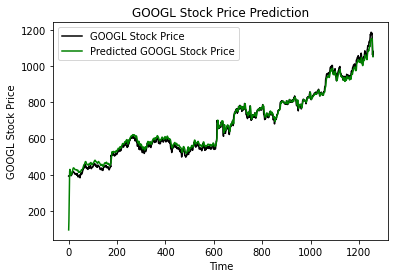

In [36]:
plt.plot(googl_real_stock_price, color = 'black', label = 'GOOGL Stock Price')
plt.plot(googl_predicted_stock_price, color = 'green', label = 'Predicted GOOGL Stock Price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGL Stock Price')
plt.legend()
plt.show()

In [37]:
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()

# average squared difference between the forecasted and actual values, stability of the model
print('GOOGL MSE', mse(googl_real_stock_price, googl_predicted_stock_price).numpy())

# average value of absolute error, which can reflect the actual situation of predicted value error
print('GOOGL MAE', mae(googl_real_stock_price, googl_predicted_stock_price).numpy())

# prediction deviation proportion in terms of the real value. A metric for the forecast accuracy
print('GOOGL MAPE', mape(googl_real_stock_price, googl_predicted_stock_price).numpy())

GOOGL MSE 418.25244
GOOGL MAE 14.210677
GOOGL MAPE 2.38179
